# 01 — Data Loading, Exploration & Preprocessing

This notebook loads three binary sentiment datasets (English, French, Dutch), harmonizes their schemas, explores distributions, and saves preprocessed versions for fine-tuning.

**Datasets:**
- English: IMDB Movie Reviews (`stanfordnlp/imdb`)
- French: Allocine Movie Reviews (`tblard/allocine`)
- Dutch: DBRD Book Reviews (`benjaminvdb/dbrd`)

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, DatasetDict, concatenate_datasets
from transformers import AutoTokenizer
import torch

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DATA_DIR = "./data"
os.makedirs(DATA_DIR, exist_ok=True)

print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_mem / 1e9:.1f} GB")

PyTorch: 2.10.0
CUDA available: False


## 1. Load Raw Datasets

In [2]:
print("Loading IMDB (English)...")
imdb = load_dataset("stanfordnlp/imdb")
print(imdb)

print("\nLoading Allocine (French)...")
allocine = load_dataset("tblard/allocine")
print(allocine)

print("\nLoading DBRD (Dutch)...")
dbrd = load_dataset("benjaminvdb/dbrd")
print(dbrd)

Loading IMDB (English)...
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

Loading Allocine (French)...


DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 20000
    })
})

Loading DBRD (Dutch)...
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20028
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2224
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 96264
    })
})


## 2. Inspect Raw Data

In [3]:
print("=== IMDB Sample ===")
print(f"Columns: {imdb['train'].column_names}")
print(f"Label values: {set(imdb['train']['label'])}")
print(f"Sample: {imdb['train'][0]['text'][:200]}...\n")

print("=== Allocine Sample ===")
print(f"Columns: {allocine['train'].column_names}")
print(f"Label values: {set(allocine['train']['label'])}")
print(f"Sample: {allocine['train'][0]['review'][:200]}...\n")

print("=== DBRD Sample ===")
print(f"Columns: {dbrd['train'].column_names}")
print(f"Label values: {set(dbrd['train']['label'])}")
print(f"Sample: {dbrd['train'][0]['text'][:200]}...")

=== IMDB Sample ===
Columns: ['text', 'label']
Label values: {0, 1}
Sample: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ev...

=== Allocine Sample ===
Columns: ['review', 'label']
Label values: {0, 1}
Sample: Si vous cherchez du cinéma abrutissant à tous les étages,n'ayant aucune peur du cliché en castagnettes et moralement douteux,"From Paris with love" est fait pour vous.Toutes les productions Besson,via...

=== DBRD Sample ===
Columns: ['text', 'label']
Label values: {0, 1}
Sample: Na alle voorgaande boeken van Dan Brown gelezen te hebben, waren mijn verwachtingen voor dit boek hoog gespannen. Deze verwachtingen werden voor een groot deel ook ingelost. Het verhaal is spannend en...


## 3. Harmonize Schemas

Standardize all datasets to columns: `text`, `label` (0=negative, 1=positive), `language`.

In [4]:
def add_language(example, lang):
    example["language"] = lang
    return example

# IMDB: already has 'text' and 'label' (0=neg, 1=pos)
imdb = imdb.map(lambda x: add_language(x, "en"))

# Allocine: rename 'review' -> 'text', label is already 0=neg 1=pos
allocine = allocine.rename_column("review", "text")
allocine = allocine.map(lambda x: add_language(x, "fr"))

# DBRD: already has 'text' and 'label' (0=neg, 1=pos)
dbrd = dbrd.map(lambda x: add_language(x, "nl"))

print("Schema after harmonization:")
for name, ds in [("IMDB", imdb), ("Allocine", allocine), ("DBRD", dbrd)]:
    print(f"  {name}: {ds['train'].column_names}")

Schema after harmonization:
  IMDB: ['text', 'label', 'language']
  Allocine: ['text', 'label', 'language']
  DBRD: ['text', 'label', 'language']


## 4. Create Validation Splits

IMDB and DBRD lack explicit validation sets. We split off from training data.

In [5]:
# IMDB: split 22,500 train / 2,500 val from the 25,000 train
imdb_split = imdb["train"].train_test_split(test_size=2500, seed=SEED, stratify_by_column="label")
imdb = DatasetDict({
    "train": imdb_split["train"],
    "validation": imdb_split["test"],
    "test": imdb["test"],
})
print(f"IMDB splits: {imdb}")

# DBRD: split 18,000 train / 2,000 val from the 20,000 train
dbrd_split = dbrd["train"].train_test_split(test_size=2000, seed=SEED, stratify_by_column="label")
dbrd = DatasetDict({
    "train": dbrd_split["train"],
    "validation": dbrd_split["test"],
    "test": dbrd["test"],
})
print(f"DBRD splits: {dbrd}")

# Allocine already has train/validation/test
print(f"Allocine splits: {allocine}")

IMDB splits: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 2500
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 25000
    })
})
DBRD splits: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 18028
    })
    validation: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 2224
    })
})
Allocine splits: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 160000
    })
    validation: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 200

## 5. Subsample Allocine for Balance

Allocine has 160k training examples — subsample to 25k to match IMDB.

In [6]:
allocine_train_sub = allocine["train"].shuffle(seed=SEED).select(range(25000))
allocine = DatasetDict({
    "train": allocine_train_sub,
    "validation": allocine["validation"],
    "test": allocine["test"],
})
print(f"Allocine after subsampling: {allocine}")

Allocine after subsampling: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 20000
    })
})


## 6. Label Distribution

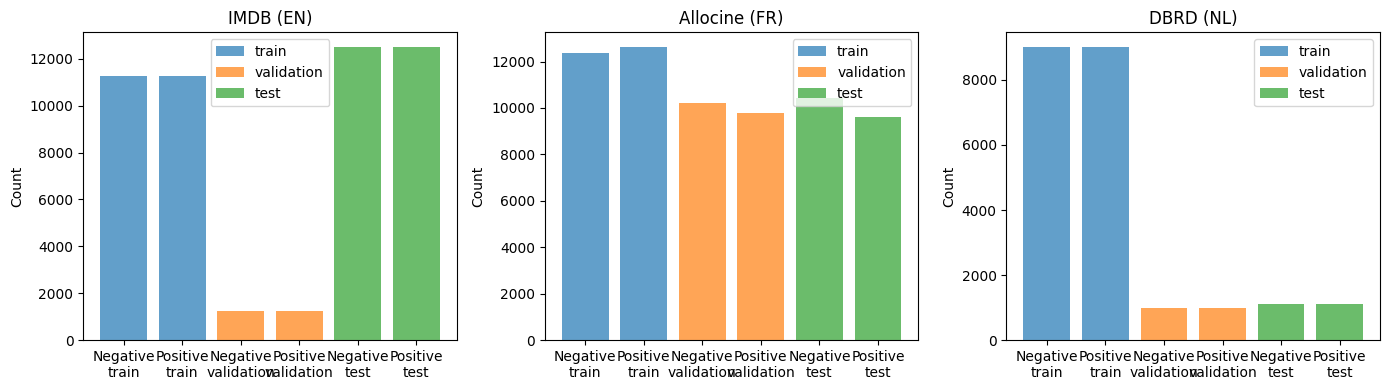

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
label_names = ["Negative", "Positive"]

for ax, (name, ds) in zip(axes, [("IMDB (EN)", imdb), ("Allocine (FR)", allocine), ("DBRD (NL)", dbrd)]):
    for split in ["train", "validation", "test"]:
        labels = ds[split]["label"]
        counts = [labels.count(0), labels.count(1)]
        ax.bar([f"{l}\n{split}" for l in label_names], counts, alpha=0.7, label=split)
    ax.set_title(name)
    ax.set_ylabel("Count")
    ax.legend()

plt.tight_layout()
plt.savefig("./results/figures/label_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

## 7. Text Length Analysis

Analyze token counts using the mBERT tokenizer to inform our `max_length` choice.

Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors


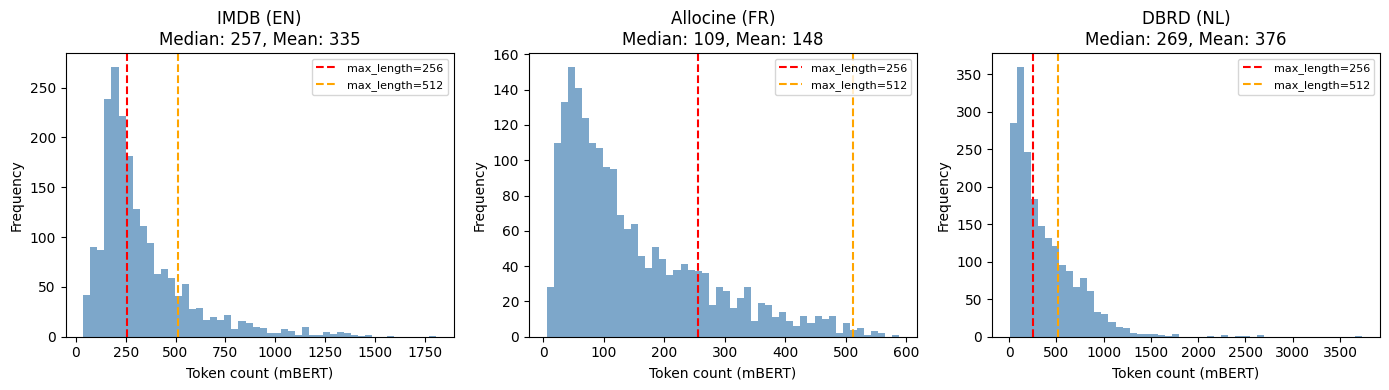

Percentage of texts under 256 tokens:
  IMDB: 49.6%
  Allocine: 82.3%
  DBRD: 48.4%


In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (name, ds, lang) in zip(axes, [
    ("IMDB (EN)", imdb, "en"),
    ("Allocine (FR)", allocine, "fr"),
    ("DBRD (NL)", dbrd, "nl"),
]):
    # Sample 2000 texts for speed
    sample = ds["train"].shuffle(seed=SEED).select(range(min(2000, len(ds["train"]))))
    lengths = [len(tokenizer.encode(t, truncation=False)) for t in sample["text"]]
    
    ax.hist(lengths, bins=50, alpha=0.7, color="steelblue")
    ax.axvline(x=256, color="red", linestyle="--", label="max_length=256")
    ax.axvline(x=512, color="orange", linestyle="--", label="max_length=512")
    ax.set_title(f"{name}\nMedian: {int(np.median(lengths))}, Mean: {int(np.mean(lengths))}")
    ax.set_xlabel("Token count (mBERT)")
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig("./results/figures/token_length_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

print("Percentage of texts under 256 tokens:")
for name, ds in [("IMDB", imdb), ("Allocine", allocine), ("DBRD", dbrd)]:
    sample = ds["train"].shuffle(seed=SEED).select(range(min(2000, len(ds["train"]))))
    lengths = [len(tokenizer.encode(t, truncation=False)) for t in sample["text"]]
    pct = sum(1 for l in lengths if l <= 256) / len(lengths) * 100
    print(f"  {name}: {pct:.1f}%")

## 8. Summary Statistics

In [9]:
summary = []
for name, ds, lang in [("IMDB", imdb, "EN"), ("Allocine", allocine, "FR"), ("DBRD", dbrd, "NL")]:
    for split in ["train", "validation", "test"]:
        labels = ds[split]["label"]
        summary.append({
            "Dataset": name,
            "Language": lang,
            "Split": split,
            "Size": len(ds[split]),
            "Positive %": f"{sum(labels) / len(labels) * 100:.1f}%",
        })

df_summary = pd.DataFrame(summary)
print(df_summary.to_string(index=False))

 Dataset Language      Split  Size Positive %
    IMDB       EN      train 22500      50.0%
    IMDB       EN validation  2500      50.0%
    IMDB       EN       test 25000      50.0%
Allocine       FR      train 25000      50.5%
Allocine       FR validation 20000      49.0%
Allocine       FR       test 20000      48.0%
    DBRD       NL      train 18028      50.0%
    DBRD       NL validation  2000      50.0%
    DBRD       NL       test  2224      50.0%


## 9. Save Preprocessed Datasets

In [10]:
# Save individual language datasets
imdb.save_to_disk(os.path.join(DATA_DIR, "en"))
allocine.save_to_disk(os.path.join(DATA_DIR, "fr"))
dbrd.save_to_disk(os.path.join(DATA_DIR, "nl"))

# Create and save combined multilingual dataset
combined = DatasetDict({
    split: concatenate_datasets([
        imdb[split],
        allocine[split],
        dbrd[split],
    ]).shuffle(seed=SEED)
    for split in ["train", "validation", "test"]
})
combined.save_to_disk(os.path.join(DATA_DIR, "combined"))

print(f"Combined multilingual dataset: {combined}")
print(f"\nAll datasets saved to {DATA_DIR}/")
print("  - en/ (IMDB)")
print("  - fr/ (Allocine)")
print("  - nl/ (DBRD)")
print("  - combined/ (all three)")

Saving the dataset (0/1 shards):   0%|          | 0/22500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18028 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2224 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/65528 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/24500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/47224 [00:00<?, ? examples/s]

Combined multilingual dataset: DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 65528
    })
    validation: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 24500
    })
    test: Dataset({
        features: ['text', 'label', 'language'],
        num_rows: 47224
    })
})

All datasets saved to ./data/
  - en/ (IMDB)
  - fr/ (Allocine)
  - nl/ (DBRD)
  - combined/ (all three)
